In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

import scipy.spatial.distance as spd
import scipy.stats as sps

import seqerr_utils as squ
import pathlib

In [2]:
# create folder in which to save the figures
svfig = pathlib.Path('figs/seq_err_correction')
svfig.mkdir(exist_ok=True, parents=True)

## Extract reads from left side - round 8

Nb: data must first be downloaded following instructions reported from the README file. In particular, file `s100_8th.fasta` must be present in the `data` folder (see line below).

In [3]:
# fasta file containing the reads for left side, round 8
data_file = pathlib.Path('data/s100_8th.fasta')

# import data and select only the left loop
df = squ.import_data(data_file)
df = squ.project_on_side(df, side='left')

In [4]:
# dataframe with sequences and counts
df

,counts
seq,
AGGGATGATGTGTGGTAGGC,8034
AGGGTAGGTGTGGATGATGC,7948
GTAGGATGGGTAGGGTGGTC,5146
AGGGTAGGCGTGGATGATGC,4507
AGGGTAGGAGTGGATGATGC,4375
...,...
GAAAGGATGGTAGGTTGGTC,1
GAAAGGATGGTATGGTTGGG,1
GAAAGGATGGTGGGTTGGGC,1


## Generate the first figure

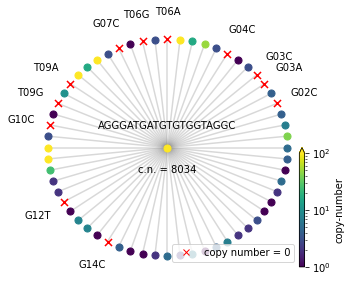

In [5]:
# length of sequences
L = 20

# set of nucleotides
nucl = ['A', 'C', 'G', 'T']

# main sequence
mseq = df.index[0]


def draw_scheme(ax):
    '''function to draw the radial scheme representing the sequence
    space around the most abundant sequence.'''

    # setup colormap
    cmap = mpl.cm.viridis
    norm = mpl.colors.LogNorm(1,1e2)
    mapp = mpl.cm.ScalarMappable(norm, cmap)

    def draw_leaf(alpha, mut, count, ax, r=1., dr=0.25):
        '''Function to draw a single leaf of the radial graph'''

        # draw stem
        x,y = r*np.cos(alpha), r*np.sin(alpha)
        ax.plot([0,x],[0,y], 'gray', alpha=0.3)
        if count > 0:
            c, m = cmap(norm(count)), 'o'
        else:
            c, m = 'red', 'x'

        # draw symbol
        ax.scatter([x],[y],color=c, marker=m, zorder=3, s=50)
        if count == 0:
            ax.text(x*(r+dr)/r, y*(r+dr)/r, mut, horizontalalignment='center', verticalalignment='center')

    # draw center
    ax.scatter([0], [0], color=cmap(norm(df.loc[mseq].counts)), zorder=3, s=50)
    ax.text(0,0.2, mseq, horizontalalignment='center', verticalalignment='center')
    ax.text(0,-0.2, f'c.n. = {int(df.loc[mseq].counts)}', horizontalalignment='center', verticalalignment='center')


    # go around the circle, for each angle consider
    # a different single-site mutation and check
    # its number of counts in the dataset
    alpha = 0.
    dalpha = 2*np.pi / (L*3)
    for l in range(L): # for every position
        for nt in nucl: # for every possible mutation
            if mseq[l] == nt:
                continue # skip the case of no mutation

            # create mutated sequence
            nseq = list(mseq)
            nseq[l] = nt
            nseq = ''.join(nseq)

            # label for mutation
            mut = f'{mseq[l]}{l+1:02}{nt}'

            # number of counts
            if nseq in df.index:
                count = df.loc[nseq].counts
            else:
                count = 0

            # draw the radial stem and increase the angle
            draw_leaf(alpha, mut, count, ax)
            alpha += dalpha

    # adjust axes, colobar and legend
    for sp in ax.spines:
        ax.spines[sp].set_visible(False)
    ax.set_xticks([])
    ax.set_yticks([])
    cax = ax.inset_axes([1., 0., 0.02, 0.5], transform=ax.transAxes)
    plt.colorbar(mapp, ax=ax, cax=cax, extend='max',
        label='copy-number', shrink=0.5, pad=-0.2)
    legend_elements = [mpl.lines.Line2D([0], [0], color='r',
                                        marker='x',ls='',
                                        label='copy number = 0')]
    ax.legend(handles=legend_elements, loc='lower right')
    
fig, ax = plt.subplots(1,1, figsize=(5,4))
draw_scheme(ax)
plt.tight_layout()
plt.savefig(svfig / 'panel_A.pdf')
plt.show()            

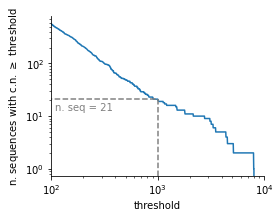

In [6]:
# threshold number of counts
cn_thr = 1000

# selected peaks
peak_mask = df['counts'] >= cn_thr
n_peaks = peak_mask.sum()

def remove_spines(ax, spines=['top', 'right']):
    '''Utility function to remove spines'''
    for sp in spines:
        ax.spines[sp].set_visible(False)

def draw_peaks_distr(ax):
    '''function to draw the number of peaks as a function of
    the threshold number of counts.'''

    # list of threshold values
    thrs = np.logspace(2,4,1000)
    
    # resulting number of peaks
    npeaks = np.zeros_like(thrs)
    for i, th in enumerate(thrs):
        npeaks[i] = np.sum(df['counts'] >= th)

    ax.plot(thrs, npeaks)
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlim(1e2, 1e4)
    ax.set_xlabel('threshold')
    ax.set_ylabel('n. sequences with c.n. $\geq$ threshold')
    
    ax.plot([0, cn_thr, cn_thr], [n_peaks, n_peaks,0], c='gray', ls='--', scaley=False)
    ax.text(110, n_peaks*(0.6), f'n. seq = {n_peaks}', color='gray')
    remove_spines(ax)
        
fig, ax = plt.subplots(1,1, figsize=(4,3))
draw_peaks_distr(ax)
plt.tight_layout()
plt.savefig(svfig / 'panel_B.pdf')
plt.show()            

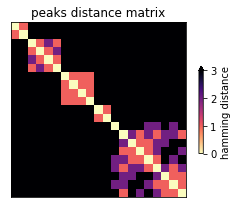

In [7]:
# select peak sequences
df_peak = df[peak_mask]
peak_Seq = squ.nt_to_matrix(df_peak.index)

# perform hierarchical clustering of the distance matrix
from scipy.cluster import hierarchy
D = spd.pdist(peak_Seq, metric='hamming')
Z = hierarchy.linkage(D)
D = spd.squareform(D) * L
ll = hierarchy.leaves_list(Z)
D=D[ll,:][:,ll]

def draw_distmat(ax):
    '''function to visualize the hierarchically-clustered distance matrix'''
    cmap = mpl.cm.magma_r
    norm = mpl.colors.Normalize(vmin=0, vmax=3)
    mapp = mpl.cm.ScalarMappable(norm, cmap)
    ax.matshow(D, norm=norm, cmap=cmap)
    plt.colorbar(mapp, ax=ax, extend='max', label='hamming distance', shrink=0.5)
    ax.set_title(f'peaks distance matrix')
    ax.set_xticks([])
    ax.set_yticks([])

fig, ax = plt.subplots(1,1, figsize=(4,3))
draw_distmat(ax)
plt.tight_layout()
plt.savefig(svfig / 'panel_C.pdf')
plt.show()

In [8]:
import scipy.stats as sps
from scipy.optimize import minimize_scalar

def peak_neighbours_cn(cdict, ps):
    '''for a given peak sequence (ps) it returns the list of
    copy numbers of all possible single-mutation neighbors. The
    list contains zeros corresponding to missing neighbors'''
   
    cn = [] # list of copy numbers
    
    psa = squ.nt_to_array(ps)


    for i in range(len(psa)):
        for _ in range(3):
            # add mutation on site i
            psa[i] = (psa[i] + 1) % 4 
            
            # check if the sequence is present in data, and append
            # copy number
            idx = tuple(psa)
            if idx in cdict:
                cn.append(cdict[idx])
            else:
                cn.append(0)
            
        # remove the mutation on site i
        psa[i] = (psa[i] + 1) % 4

    return np.array(cn)

def peak_neighborhood_copy_number(df, peak_seqs):
    '''Given a list of peak sequences, creates a list of copy numbers
    of all possible single-site mutants of each peak sequence'''
    
    # matrix representing a list of nucleotide sequences as integers
    S = squ.nt_to_matrix(df.index)
    # copy number of sequences
    counts = df.counts
    # count dictionary
    cdict = {tuple(s) : c for s,c in zip(S, counts)}
    
    # for each sequence in the list, recover the copy numbers of all
    # possible single-site mutations.
    n_counts = []
    for ps in peak_seqs:
        nc = peak_neighbours_cn(cdict, ps)
        n_counts.append(nc)

    return n_counts
        


# copy-numbers of all neighbors for all peaks
n_counts = peak_neighborhood_copy_number(df, df_peak.index)


def log_likelihood(eps, N_counts, n_counts, L=20, thr=None):
    '''Evaluate the log-likelihood of the data for a given
    value of the error probability epsilon'''
    logl = []
    p_err = (eps/3.)*(1-eps)**(L-1)
    p_corr = (1-eps)**L
    for N,nc in zip(N_counts, n_counts):
        N_corr = N/p_corr
        q = np.power(1. - p_err, N_corr)
        ntot = 3*L
        
        n0 = np.sum(nc==0)
        
        if thr is not None:
            ntot = np.sum(nc <= thr)

        log_pn0 = sps.binom.logpmf(n0, ntot, q)
        
        logl.append(log_pn0)
    
    return logl

# list of possible values for the single-site reading error probability
eps_list = np.logspace(-5,-1,50)

# copy-number threshold at which to consider a sequence as not resulting
# from reading error
inference_threshold_n = 10

# evaluate the log-likelihood for all values of epsilon
logl = []
for eps in eps_list:
    ll = log_likelihood(eps, df_peak.counts, n_counts, thr=None)
    logl.append(np.mean(ll))

# evaluate the log-likelihood, excluding sequences that have more than
# `inference_threshold_n` counts
logl_corr = []
for eps in eps_list:
    ll = log_likelihood(eps, df_peak.counts, n_counts, thr=inference_threshold_n)
    logl_corr.append(np.mean(ll))        

# find the maximum-likelihood value of epsilon
simple_mll = lambda x : -np.sum(log_likelihood(x, df_peak.counts,
                                n_counts))
sol_simple = minimize_scalar(simple_mll, bracket=[1e-4,1e-3,1e-2],
                            bounds=(1e-4,1e-1))
eps_s = sol_simple.x

# find the maximum-likelihood value of epsilon, excluding sequences with
# more than `inference_threshold_n` counts.
threshold_mll = lambda x : -np.sum(log_likelihood(x, df_peak.counts, n_counts,
                                                  20, inference_threshold_n))
sol_threshold = minimize_scalar(threshold_mll, bracket=[1e-4,1e-3,1e-2],
                                bounds=(1e-4,1e-1))
eps_t = sol_threshold.x

def fit_deg2pol(best, func):
    '''function to fit a second degree polynomial'''
    x = np.logspace(np.log10(best)-0.02, np.log10(best) +0.02, 20)
    y = [- func(xi) for xi in x]
    p = np.polyfit(x,y,deg=2)
    return p

def find_std(best, func):
    '''Find a proxy for the standard deviation using a second
    degree fit of the log-likelihood'''
    p = fit_deg2pol(best, func)
    sigma = np.sqrt(1./(-2*p[0]))
    return sigma

# use the curvature of the log-likelihood around the MLE to recover
# a measure of uncertainty of the estimate
delta_s = find_std(eps_s, simple_mll)
delta_t = find_std(eps_t, threshold_mll)

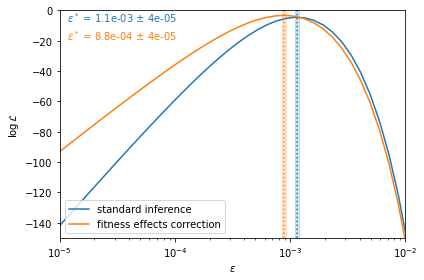

In [9]:
def draw_logl(ax):
    
    ax.set_ylim(top=0, bottom=-150)
    ax.set_xlim(1e-5, 1e-2)
    ax.set_xscale('log')
    ax.set_xlabel(r'$\epsilon$')
    ax.set_ylabel(r'$\log \mathcal{L}$')

    # plot the likelihoods
    ax.plot(eps_list, logl, '-', label=f'standard inference')
    ax.plot(eps_list, logl_corr, '-',label=f'fitness effects correction')

    # plot the means and variances
    ax.axvline(eps_s, c='C0', ls=':')
    ax.axvline(eps_t, c='C1', ls=':')

    ax.axvspan(eps_s - delta_s, eps_s + delta_s, alpha=0.2, color='C0')
    ax.axvspan(eps_t - delta_t, eps_t + delta_t, alpha=0.2, color='C1')

    ax.text(.02,0.95,f'$\epsilon^*$ = {eps_s:1.1e} $\pm$ {delta_s:.1}', color='C0', transform=ax.transAxes)
    ax.text(.02,0.87,f'$\epsilon^*$ = {eps_t:1.1e} $\pm$ {delta_t:.1}', color='C1', transform=ax.transAxes)

    ax.legend(loc=3)

fig, ax = plt.subplots(1,1,figsize=(6,4))
draw_logl(ax)
plt.tight_layout()
plt.savefig(svfig / 'panel_D.pdf')
plt.show()

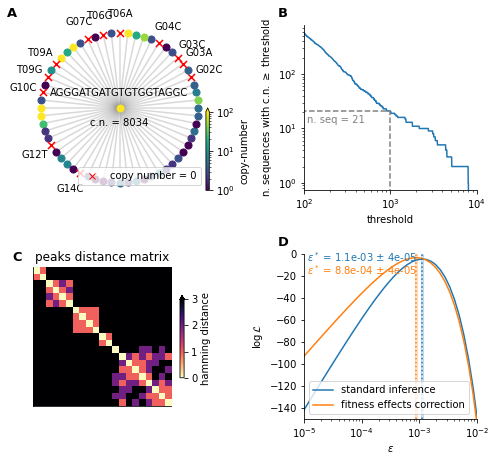

In [10]:
# put all the panels together in a single figure
fig = plt.figure(figsize=(7,6.5), constrained_layout=False)

gs = mpl.gridspec.GridSpec(2, 2, figure=fig)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[1, 0])
ax4 = fig.add_subplot(gs[1, 1])


draw_scheme(ax1)
draw_peaks_distr(ax2)
draw_distmat(ax3)
draw_logl(ax4)


for nax, axi in enumerate([ax1, ax2, ax3, ax4]):
    axi.spines['top'].set_visible(False)
    axi.spines['right'].set_visible(False)
    axlab = {0:'A', 1:'B', 2:'C', 3:'D'}
    axi.text(-0.15,1.05,axlab[nax],transform=axi.transAxes, size=13, weight='bold')

plt.tight_layout()
plt.savefig(svfig / 'fig_seqerr_1.pdf')
plt.show()


## Evaluate the probability of being an error and generate the second figure

In [11]:
# arrays of sequences and counts
seqs = df.index.to_list()
counts = df.counts.to_numpy()

# single-site error probability
eps = 0.001

# generate error probability for each sequence
p_err = squ.greedy_seqremoval(seqs, counts, eps)

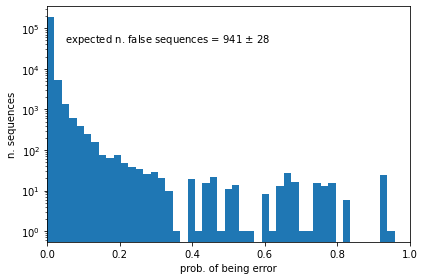

In [12]:
# average and standard deviation of number of errors
avg_nerr = np.sum(p_err)
std_nerr = np.sqrt(np.sum(p_err * (1. - p_err)))

def draw_perr(ax):
    '''draws the distribution of sequence error probabilities.'''
    bins = np.linspace(0,1,50)
    bins = np.append(bins,2)
    ax.hist(p_err, bins=bins, cumulative=False, histtype='stepfilled')
    ax.set_xlim(0,1)
    ax.set_yscale('log')
    ax.set_xlabel('prob. of being error')
    ax.set_ylabel('n. sequences')
    ax.text(.05,0.85,f'expected n. false sequences = {int(avg_nerr)} $\pm$ {int(std_nerr)}', transform=ax.transAxes)

fig, ax = plt.subplots(1,1,figsize=(6,4))
draw_perr(ax)
plt.tight_layout()
plt.savefig(svfig / 'fig_seqerr_2.pdf')
plt.show()